From https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [1]:
import re
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', -1)
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

C:\Users\Gab\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\Gab\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: cymem.cymem.Pool size changed, may indicate binary incompatibility. Expected 48 from C header, got 64 from PyObject
  return f(*args, **kwds)
C:\Users\Gab\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: cymem.cymem.Address size changed, may indicate binary incompatibility. Expected 24 from C header, got 40 from PyObject
  return f(*args, **kwds)


In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
fil_stop_words = []
with open('assets/stop_words_ph.txt') as f:
    for word in f:
        fil_stop_words.append(word.rstrip('\n'))

In [3]:
# Import Dataset
text_data = []
df = pd.read_csv('data/posts_data.csv')
data = df['Body']
data.dropna(inplace=True)

In [4]:
df[0:15]

,Title,Body,Submitted
0,17054,Does anyone get blisters on their feet from walking so much around school?,"November 23, 2018 11"
1,17053,It's been a few months since that whole sexual harassment scandal rocked ateneo. The silence is deafening. Some of the profs who have been so vocal about issues like martial law etc never spoke up about this particular issue. And now they're opening up about that fucking upsilon scandal like it's the worst shit ever? Fuck you hypocrites.,"November 23, 2018 10"
2,17052,"I think the reason why we really hate Filipino in college is not because of the language, but the topics in it. I’d understand if Filipino was about learning how to speak deeper Tagalog, learning like street tagalog culture, or anything related at our present times. \r\nInstead college Filipino (at least what i experienced here) for me had very unnecessary or lack of better term, useless topics. Lol So in Filipino, we learn about a girl falling in love with nature getting horny, we learn about the ancient Filipinos and their super weird cultures, and we are REQUIRED to memorize authors of books that we’ll probably never read again. What I’m trying to say is that these topics are not very applicable in our present society. Sure i can understand a girl loves nature, sure i can study about the ancient Filipino culture, sure i can memorize random authors names, BUT in the end, after I graduate, I’m sure all these things I learned will be forgotten simply because they’re useless. It’s not very applicable in life to talk about authors I memorized lol. I guess thats why people are against the Filipino subject. It’s not because Filipino sucks, it’s more because the topics being taught are really useless...","November 23, 2018 10:33:48 AM +08"
3,17051,"Tangina this OBF wifi is pure shit. \r\nTo all those people who say that there are thousands of students here in ateneo, well guess what, we PAID THOUSANDS for internet in campus. You guys backing up the IT team or whatever are just naive. They are supposed to have enough funds to connect us and have stable internet. -.-\r\nEverywhere I go, lagi may nagdadala ng mobile wifi or personal hotspot. Accept na nila na the school wifi is not trustable. But that is not fair. Lol they were taken advantage of. They paid to have internet, and never got what they paid for. Instead they had to pay even more (hotspot or mobile wifi) to have wifi. \r\n Edi sana tanggalin nlg un internet sa school tuition noh?","November 23, 2018 10:17:39 AM +08"
4,17050,Sometimes mood: puTanGinAaaAAaAa\r\n\r\n24/7 mood: putangina But current mood: putANGINAAAAAA Ugh. Life. Fuck it. Jk I have acads to pursue :'>,"November 23, 2018 10:15:55 AM +08"
5,17049,The Marisol PA announcements really need more thought and effort put into them :((\r\nI honestly feel more discouraged to watch because of how hastily prepared them sound :((,"November 23, 2018 10:02:43 AM +08"
6,17048,https://tonite.abante.com.ph/ateneo-student-ginulpi-hinolda…\r\n\r\nTag away,"November 23, 2018 9:55:58 AM +08"
7,17047,GRABE ANG LUBAK SA COVERED COURTS WTF,"November 23, 2018 9"
8,17046,I'm free-falling and I'm not sure if you're there to catch me at the bottom.,"November 23, 2018 8"
9,17045,I thought that the east carpark is strictly for students only? Why is there a white Innova parked beside me with a driver in it?,"November 23, 2018 8"


In [5]:
# Convert to list
data = df['Body'].values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

# Remove Other ADMU FW mentions
data = [re.sub('\#ADMUFreedomWall\ \d+', '', sent) for sent in data]
data = [re.sub('\#ADMUFreedomWall\d+', '', sent) for sent in data]

pprint(data[:15])

['Does anyone get blisters on their feet from walking so much around school?',
 'Its been a few months since that whole sexual harassment scandal rocked '
 'ateneo. The silence is deafening. Some of the profs who have been so vocal '
 'about issues like martial law etc never spoke up about this particular '
 'issue. And now theyre opening up about that fucking upsilon scandal like its '
 'the worst shit ever? Fuck you hypocrites.',
 'I think the reason why we really hate Filipino in college is not because of '
 'the language, but the topics in it. I’d understand if Filipino was about '
 'learning how to speak deeper Tagalog, learning like street tagalog culture, '
 'or anything related at our present times. Instead college Filipino (at least '
 'what i experienced here) for me had very unnecessary or lack of better term, '
 'useless topics. Lol So in Filipino, we learn about a girl falling in love '
 'with nature getting horny, we learn about the ancient Filipinos and their '
 'super w

In [6]:
# Tokenizing
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['does', 'anyone', 'get', 'blisters', 'on', 'their', 'feet', 'from', 'walking', 'so', 'much', 'around', 'school']]


In [7]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

C:\Users\Gab\Anaconda3\lib\site-packages\gensim\models\phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['does', 'anyone', 'get', 'blisters', 'on', 'their', 'feet', 'from', 'walking', 'so', 'much', 'around', 'school']


In [8]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    output = [[word for word in simple_preprocess(str(doc)) if (word not in stop_words and word not in fil_stop_words)] for doc in texts]
    return output
    
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [9]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

C:\Users\Gab\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: cymem.cymem.Pool size changed, may indicate binary incompatibility. Expected 48 from C header, got 64 from PyObject
  return f(*args, **kwds)
C:\Users\Gab\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: cymem.cymem.Address size changed, may indicate binary incompatibility. Expected 24 from C header, got 40 from PyObject
  return f(*args, **kwds)


In [10]:
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['anyone', 'get', 'blister', 'foot', 'walk', 'much', 'school']]


In [11]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)]]


In [12]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=14, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [13]:
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.037*"step" + 0.029*"break" + 0.021*"sobrang" + 0.020*"https" + '
  '0.020*"tag" + 0.018*"relationship" + 0.018*"tangina" + 0.018*"com" + '
  '0.013*"sayo" + 0.011*"joke"'),
 (1,
  '0.036*"ateneo" + 0.034*"thank" + 0.025*"car" + 0.025*"parking" + '
  '0.016*"campus" + 0.016*"school" + 0.013*"pay" + 0.013*"team" + '
  '0.012*"student" + 0.011*"nutriasia"'),
 (2,
  '0.018*"play" + 0.017*"share" + 0.017*"die" + 0.016*"lose" + 0.012*"oof" + '
  '0.011*"hold" + 0.011*"heart" + 0.010*"next" + 0.010*"nice" + '
  '0.010*"better"'),
 (3,
  '0.032*"leave" + 0.025*"university" + 0.016*"wrong" + 0.015*"fail" + '
  '0.014*"give" + 0.013*"buddy" + 0.013*"building" + 0.013*"new" + '
  '0.012*"probably" + 0.011*"diet"'),
 (4,
  '0.036*"atenean" + 0.026*"open" + 0.025*"s" + 0.024*"rank" + 0.019*"anyone" '
  '+ 0.018*"block" + 0.015*"stall" + 0.015*"space" + 0.012*"look" + '
  '0.011*"month"'),
 (5,
  '0.029*"study" + 0.024*"work" + 0.019*"miss" + 0.019*"group" + 0.019*"reply" '
  '+ 0.019*"mat

In [14]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.719876126633716

Coherence Score:  0.5015212328711159


In [15]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

C:\Users\Gab\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.356977  0.011135  1       1        28.292295
11    -0.242691  0.024569  2       1        11.399173
9     -0.016699  0.210284  3       1        7.013403 
13    -0.112450 -0.123179  4       1        6.939312 
2      0.081042  0.177445  5       1        6.720910 
5      0.022643 -0.189010  6       1        5.346053 
1      0.058163  0.085514  7       1        4.863673 
10     0.105861 -0.042374  8       1        4.772408 
12     0.008100 -0.015882  9       1        4.660966 
3      0.090771  0.050868  10      1        4.586893 
4      0.051643 -0.052132  11      1        4.488320 
0      0.109449 -0.021684  12      1        3.753352 
6      0.090464 -0.117499  13      1        3.703475 
8      0.110682  0.001945  14      1        3.459765 , topic_info=     Category        Freq        Term       Total  loglift  logprob
term                                                               
58    Default  210.000000  love        210.000000  30.0000  30.0000
317   Default  331.000000  not         331.000000  29.0000  29.0000
246   Default  288.000000  know        288.000000  28.0000  28.0000
294   Default  208.000000  want        208.000000  27.0000  27.0000
45    Default  140.000000  girl        140.000000  26.0000  26.0000
646   Default  107.000000  post        107.000000  25.0000  25.0000
71    Default  201.000000  s           201.000000  24.0000  24.0000
62    Default  281.000000  people      281.000000  23.0000  23.0000
67    Default  206.000000  really      206.000000  22.0000  22.0000
100   Default  232.000000  even        232.000000  21.0000  21.0000
3     Default  347.000000  get         347.000000  20.0000  20.0000
507   Default  80.000000   look        80.000000   19.0000  19.0000
143   Default  219.000000  feel        219.000000  18.0000  18.0000
588   Default  110.000000  day         110.000000  17.0000  17.0000
383   Default  92.000000   year        92.000000   16.0000  16.0000
235   Default  212.000000  friend      212.000000  15.0000  15.0000
9     Default  202.000000  be          202.000000  14.0000  14.0000
7     Default  99.000000   ateneo      99.000000   13.0000  13.0000
359   Default  199.000000  would       199.000000  12.0000  12.0000
591   Default  72.000000   keep        72.000000   11.0000  11.0000
292   Default  232.000000  make        232.000000  10.0000  10.0000
105   Default  185.000000  guy         185.000000  9.0000   9.0000 
518   Default  81.000000   yung        81.000000   8.0000   8.0000 
85    Default  204.000000  think       204.000000  7.0000   7.0000 
513   Default  66.000000   crush       66.000000   6.0000   6.0000 
4     Default  102.000000  much        102.000000  5.0000   5.0000 
285   Default  55.000000   thank       55.000000   4.0000   4.0000 
393   Default  53.000000   atenean     53.000000   3.0000   3.0000 
208   Default  74.000000   work        74.000000   2.0000   2.0000 
5     Default  111.000000  school      111.000000  1.0000   1.0000 
...       ...        ...    ...              ...      ...      ... 
1703  Topic14  12.538858   facebook    13.360683   3.3005  -4.5139 
4432  Topic14  11.930663   goo         12.752475   3.2974  -4.5636 
1700  Topic14  11.901859   girlfriend  12.723672   3.2972  -4.5661 
4433  Topic14  10.718021   gsheet      11.539842   3.2901  -4.6708 
1844  Topic14  9.258932    ganda       10.080746   3.2789  -4.8172 
2534  Topic14  8.248989    picture     9.070793    3.2690  -4.9327 
1850  Topic14  8.179853    som_for     9.001680    3.2682  -4.9411 
2077  Topic14  7.670006    access      8.491810    3.2622  -5.0054 
1630  Topic14  7.478458    pic         8.300264    3.2597  -5.0307 
830   Topic14  7.377151    kanina      8.198975    3.2583  -5.0444 
693   Topic14  7.312685    date        8.134491    3.2575  -5.0531 
4434  Topic14  6.936273    hswkaf      7.758091    3.2520  -5.1060 
4438  Topic14  6.936273    uueikc

# Using Mallet

In [16]:
mallet_path = 'C:\\Mallet/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=14, id2word=id2word)

In [17]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(2,
  [('work', 0.05596234309623431),
   ('people', 0.04707112970711297),
   ('time', 0.04131799163179916),
   ('thing', 0.03922594142259414),
   ('org', 0.038179916317991634),
   ('good', 0.0350418410041841),
   ('group', 0.027196652719665274),
   ('filipino', 0.026673640167364017),
   ('idea', 0.016736401673640166),
   ('college', 0.015690376569037656)]),
 (11,
  [('give', 0.05146198830409357),
   ('play', 0.027485380116959064),
   ('person', 0.02631578947368421),
   ('people', 0.025146198830409357),
   ('love', 0.023391812865497075),
   ('country', 0.019883040935672516),
   ('message', 0.01929824561403509),
   ('watch', 0.016374269005847954),
   ('bring', 0.015789473684210527),
   ('stop', 0.015789473684210527)]),
 (3,
  [('cute', 0.029131985731272295),
   ('ill', 0.019024970273483946),
   ('comment', 0.019024970273483946),
   ('treat', 0.016646848989298454),
   ('short', 0.013079667063020214),
   ('business', 0.011890606420927468),
   ('cut', 0.011296076099881093),
   ('paper', 0.

In [22]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [40]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

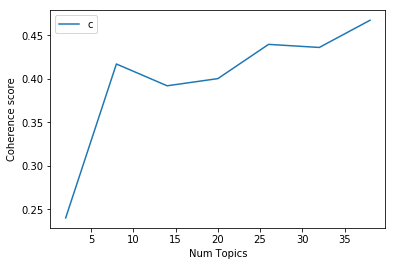

In [24]:
# Show graph
# Optimal number around 15
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [25]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2401
Num Topics = 8  has Coherence Value of 0.4171
Num Topics = 14  has Coherence Value of 0.392
Num Topics = 20  has Coherence Value of 0.4003
Num Topics = 26  has Coherence Value of 0.4396
Num Topics = 32  has Coherence Value of 0.4361
Num Topics = 38  has Coherence Value of 0.4674


In [26]:
# Select the model and print the topics
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.031*"watch" + 0.031*"love" + 0.026*"leave" + 0.024*"good" + 0.023*"girl" '
  '+ 0.020*"freshie" + 0.020*"stop" + 0.018*"hope" + 0.018*"mind" + '
  '0.016*"relationship"'),
 (1,
  '0.045*"good" + 0.021*"wrong" + 0.021*"bad" + 0.018*"idea" + 0.017*"pay" + '
  '0.015*"graduate" + 0.014*"listen" + 0.014*"put" + 0.013*"grade" + '
  '0.011*"party"'),
 (2,
  '0.083*"love" + 0.080*"feel" + 0.051*"guy" + 0.038*"make" + 0.025*"talk" + '
  '0.024*"give" + 0.023*"people" + 0.020*"nice" + 0.018*"call" + 0.015*"care"'),
 (3,
  '0.048*"people" + 0.033*"post" + 0.026*"lot" + 0.023*"thing" + '
  '0.021*"atenean" + 0.016*"money" + 0.015*"big" + 0.015*"marketing" + '
  '0.013*"point" + 0.012*"straight"'),
 (4,
  '0.055*"class" + 0.042*"time" + 0.023*"wanna" + 0.023*"end" + 0.022*"feel" + '
  '0.018*"day" + 0.017*"start" + 0.017*"word" + 0.017*"week" + 0.014*"cookie"'),
 (5,
  '0.046*"day" + 0.036*"guy" + 0.033*"year" + 0.021*"happy" + 0.016*"happen" + '
  '0.015*"home" + 0.014*"stay" + 0.014*"w

In [27]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [28]:
# Show dominant topic in a document
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,8.0,0.0929,"school, ateneo, people, play, student, parking, country, bring, campus, important",Does anyone get blisters on their feet from walking so much around school?
1,1,13.0,0.1561,"shit, pup, post, comment, stop, team, lose, write, judge, pana",Its been a few months since that whole sexual harassment scandal rocked ateneo. The silence is deafening. Some of the profs who have been so vocal about issues like martial law etc never spoke up about this particular issue. And now theyre opening up about that fucking upsilon scandal like its the worst shit ever? Fuck you hypocrites.
2,2,11.0,0.4955,"fuck, girl, filipino, time, hate, college, treat, honestly, idk, weird","I think the reason why we really hate Filipino in college is not because of the language, but the topics in it. I’d understand if Filipino was about learning how to speak deeper Tagalog, learning like street tagalog culture, or anything related at our present times. Instead college Filipino (at least what i experienced here) for me had very unnecessary or lack of better term, useless topics. Lol So in Filipino, we learn about a girl falling in love with nature getting horny, we learn about the ancient Filipinos and their super weird cultures, and we are REQUIRED to memorize authors of books that we’ll probably never read again. What I’m trying to say is that these topics are not very applicable in our present society. Sure i can understand a girl loves nature, sure i can study about the ancient Filipino culture, sure i can memorize random authors names, BUT in the end, after I graduate, I’m sure all these things I learned will be forgotten simply because they’re useless. It’s not very applicable in life to talk about authors I memorized lol. I guess thats why people are against the Filipino subject. It’s not because Filipino sucks, it’s more because the topics being taught are really useless..."
3,3,1.0,0.3575,"good, wrong, bad, idea, pay, graduate, listen, put, grade, party","Tangina this OBF wifi is pure shit. To all those people who say that there are thousands of students here in ateneo, well guess what, we PAID THOUSANDS for internet in campus. You guys backing up the IT team or whatever are just naive. They are supposed to have enough funds to connect us and have stable internet. -.- Everywhere I go, lagi may nagdadala ng mobile wifi or personal hotspot. Accept na nila na the school wifi is not trustable. But that is not fair. Lol they were taken advantage of. They paid to have internet, and never got what they paid for. Instead they had to pay even more (hotspot or mobile wifi) to have wifi. Edi sana tanggalin nlg un internet sa school tuition noh?"
4,4,7.0,0.1095,"make, people, work, org, time, part, ateneo, group, good, life",Sometimes mood: puTanGinAaaAAaAa 24/7 mood: putangina But current mood: putANGINAAAAAA Ugh. Life. Fuck it. Jk I have acads to pursue :>
5,5,1.0,0.0968,"good, wrong, bad, idea, pay, graduate, listen, put, grade, party",The Marisol PA announcements really need more thought and effort put into them :(( I honestly feel more discouraged to watch because of how hastily prepared them sound :((
6,6,8.0,0.0826,"school, ateneo, people, play, student, parking, country, bring, campus, important",https://tonite.abante.com.ph/ateneo-student-ginulpi-hinolda… Tag away
7,7,8.0,0.0973,"school, ateneo, people, play, student, parking, country, bring, campus, important",GRABE ANG LUBAK SA COVERED COURTS WTF
8,8,5.0,0.0867,"day, guy, year, happy, happen, home, stay, walk, long, night",Im free-falling and Im not sure if youre there to catch me at the bottom.
9,9,5.0,0.1076,"day, guy, year, happy, happen, home, stay, walk, long, night",I thought that the east carpark is strictly for students only? Why is there a white Innova parked beside me with a driver in it?


## Show most dominant document in a topic

In [29]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.5434,"watch, love, leave, good, girl, freshie, stop, hope, mind, relationship","To my bestfriend, I hope that you get to read this. I am falling for you. How can I not? You have the most perfect face. You are f*king handsome. You are smart, You are responsible. You are funny. You are decent. You have so many girls crushing on you but you dont care about them. You are ambitious. You are everything good and I respect you. As your best friend, I am lucky to be the person you hug, you hold hands with, you send selfies to, you share food with, you wait for, you reserve a seat for, you offer your shoulder to sleep on... Sometimes, i wonder, do you like me? If so, are these the signals? Are you waiting for me to affirm this? But i really dont know. Coz when we arent in school, you rarely call or text. I know you said that you arent ready for any relationship yet but you know, i can wait. But i wanna know if my wait is going to be worthwhile. When you told me not to leave you ever and I said yes, i really meant it. YOu said you were kilig and I wonder what that meant? Is this purely friendship? Coz you know i really like you and i wished that you would give me hints if you like me. Just so as you know, not all chinese girls have the great wall. If thats what is stopping you. And even if there was a great wall for me, I know that you are someone my parents will surely accept. I know im not the prettiest girl, im sure you have prettier ones waiting in line. Im not the smartest either, you know that. Am I too ambitious? Well, you know its really hard to be pretending all the time. When you hold my hand, i want to lock it in mine forever. When you hug me, i want to stay that way forever. When you say dont leave me, i wanted to tell you I will be here forever.... #ME freshie in love with bestfriend"
1,1.0,0.5131,"good, wrong, bad, idea, pay, graduate, listen, put, grade, party","A general response to recent posts on hot-button social and labor issues: - Most of whats said about ""SJWs"" and the ""pa-woke"" actually present an extreme caricature and overwhelmingly do not represent anyone seeking a better society through organized social and political action. If anything, I generally see anyone bandying around comments like ""haha 3guarD sjw cuckés"" as someone unwilling to engage ideas head-on and get to the bottom of things. - Nobody is apolitical. Everything is political. Lines are drawn every time someone declares himself a ""neutral party"" to an issue. More often than not, neutrality is rooted in the belief that you have no stake in the issue, that it isnt important enough from your point of view to care. But for the labor-only contractual worker, the knife of unemployment, poverty, and hunger is constantly cold on his neck. It matters to him, and it matters to anyone who would dare demand a better world from powers-that-be. - Being 3dGy really doesnt cut it. Its not top-tier shitposting. It just exposes your prejudices."
2,2.0,0.4472,"love, feel, guy, make, talk, give, people, nice, call, care","I broke down so hard core at school today. Borderline suicidal already and stuff but what really encouraged me and made me smile despite the pain was when I got on the phone with my sister in the CR in SEC B then I guess the Ate overheard my conversation. She locked the door for me which, at first I didnt notice, but then she even encouraged me after the phone call to talk to someone if I need help and to go to the guidance office and stuff. I guess, in many ways, I regret that I only realized many minutes later that I shouldve asked for her name. My point is, love is everywhere. It was the kind of unexpected love that really threw me off guard and made me smile despite my overflowing family problems. Life is tough even for the toughest, most indestructible cookie (like I thought I was) but giving love, even to people you dont know, is important. ALSO notice the Ates at school, even those who

In [30]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,8.0,"school, ateneo, people, play, student, parking, country, bring, campus, important",138.0,0.0838
1,13.0,"shit, pup, post, comment, stop, team, lose, write, judge, pana",128.0,0.0777
2,11.0,"fuck, girl, filipino, time, hate, college, treat, honestly, idk, weird",121.0,0.0735
3,1.0,"good, wrong, bad, idea, pay, graduate, listen, put, grade, party",92.0,0.0559
4,7.0,"make, people, work, org, time, part, ateneo, group, good, life",105.0,0.0638
5,1.0,"good, wrong, bad, idea, pay, graduate, listen, put, grade, party",123.0,0.0747
6,8.0,"school, ateneo, people, play, student, parking, country, bring, campus, important",121.0,0.0735
7,8.0,"school, ateneo, people, play, student, parking, country, bring, campus, important",93.0,0.0565
8,5.0,"day, guy, year, happy, happen, home, stay, walk, long, night",131.0,0.0795
9,5.0,"day, guy, year, happy, happen, home, stay, walk, long, night",138.0,0.0838


## Exploration of shorter posts

Since it seems like long posts are skewing the topic models, get the average length of a post and then cut everything off above that

In [31]:
for row in data_lemmatized:
    print(row)

['anyone', 'get', 'blister', 'foot', 'walk', 'much', 'school']
['month', 'whole', 'sexual', 'harassment', 'scandal', 'rock', 'ateneo', 'silence', 'deafen', 'prof', 'vocal', 'issue', 'martial', 'law', 'never', 'speak', 'particular', 'issue', 'be', 'open', 'fucking', 'upsilon', 'scandal', 'bad', 'ever', 'fuck', 'hypocrite']
['think', 'reason', 'really', 'hate', 'filipino', 'college', 'language', 'topic', 'understand', 'filipino', 'learning', 'speak', 'deep', 'tagalog', 'learn', 'street', 'tagalog', 'culture', 'anything', 'relate', 'present', 'time', 'instead', 'college', 'filipino', 'least', 'experience', 'unnecessary', 'lack', 'good', 'term', 'useless', 'topic', 'filipino', 'learn', 'girl', 'fall', 'love', 'nature', 'get', 'horny', 'learn', 'ancient', 'filipino', 'super', 'weird', 'culture', 'require', 'memorize', 'author', 'book', 'probably', 'never', 'read', 'try', 'say', 'topic', 'applicable', 'present', 'society', 'sure', 'understand', 'girl', 'love', 'nature', 'sure', 'study', 'anc

['anon', 'use', 'newbie', 'org', 'bad', 'experience', 'life', 'feel', 'work', 'people', 'primary', 'intention', 'receive', 'attention', 'high', 'dose', 'fame', 'disgust', 'good', 'people', 'sure', 'whole', 'work', 'environment', 'terrify', 'work', 'set', 'mood', 'freshie', 'life', 'back', 'say', 'dread', 'life', 'thankful', 'get', 'still', 'wish', 'would', 'change', 'everything', 'remain', 'hopeful', 'year', 'newbie', 'save', 'choose', 'stay', 'org', 'change', 'good', 'craft', 'reputation']
['who', 's', 'close', 'block', 'look', 'aegis', 'block', 'photoshoot', 'look', 'close']
['strongman', 'leader', 'love', 'jinping']
['yung', 'masakit', 'yung', 'kinuwento', 'kaibigan', 'crush', 'nag']
['ugly', 'make', 'sad']
['really', 'really', 'want', 'say', 'fuckinnnnng', 'sad', 'would', 'ever', 'think', 'send', 'everyone', 'think', 'always', 'happy']
['empire', 'topple', 'enemy', 'rise', 'crumble', 's', 'dead', 'forever', 'helmut', 'zemo', 'civil', 'war']
['oaa', 'ask', 'kelan', 'dadat', 'allowan

['put', 'sose', 'theory', 'test', 'rich', 'average', 'soh', 'major', 'average', 'sose', 'major', 'sose', 'supremacist', 'would', 'contend', 'soh_major', 'rich', 'could', 'afford', 'soh_major', 'average', 'soh', 'job', 'pay', 'less', 'average', 'sose', 'job', 'emphasis', 'average', 'go', 'tail', 'mean', 'average', 'way', 'can', 'not', 'cross', 'river', 'average', 'foot', 'deep', 'hand', 'parent', 'low', 'net', 'worth', 'incline', 'sway', 'kid', 'sose', 'necessarily', 'highschool', 'begin', 'kid', 'live', 'thus', 'kid', 'force', 'sose', 'rather', 'kid', 'show', 'wonder', 'math', 'science', 'birth', 'soh_major', 'parent', 'likely', 'rich', 'soh_major']
['way', 'lan', 'party', 'mateo', 'computer']
['safe']
['here', 'real', 'tea', 'theatre', 'theatre', 'org', 'org', 'make', 'clique', 'clique', 'be', 'go', 'live', 'miserable', 'lonely', 'life', 'make', 'mistake', 'worry', 'will', 'judge', 'move', 'make', 'reeeaaalllyyy', 'make', 'feel', 'unwelcome', 'time', 'walk', 'room', 'bourgeois', 'kid'

['okay', 'here', 'update', 'post', 'submit', 'back', 'september', 'reference', 'palapit', 'final', 'reason', 'still', 'fuckin', 'attract', 'classmate', 'find', 'super', 'duper', 'cute', 'wth', 'patapos', 'yung', 'sem', 'tapos', 'nangyayari', 'bobo', 'kinda', 'hate', 'tangina', 'gusto', 'huhu', 'give', 'try', 'halaman', 'altogether', 'also', 'kinda', 'give', 'point', 'sobrang', 'kam', 'common', 'friend', 'circle', 'common', 'activity', 'class', 'together', 'super', 'obvious', 'get', 'feel', 'sinusungitan', 'ergo', 'interested', 'tapo', 'nowhere', 'kinausap', 'class', 'know', 'that', 's', 'isipin', 'isipin', 'yung', 'sobrang', 'crush', 'crush', 'tao', 'tapos', 'sinungitan', 'kumbinsado', 'ayaw', 'ayaw', 'sayo', 'tapos', 'kakausapin', 'naku', 'kuya', 'mahirap', 'maropoque', 'ayan', 'naloka', 'tumingin', 'ulit', 'horoscope', 'reference', 'sort', 'type', 'sign', 'yung', 'girl', 'yung', 'magmamake', 'first', 'move', 'honestly', 'sobrang', 'bobo', 'really', 'go', 'base', 'action', 'natal', 'c

['grade', 'classmate', 'fill', 'empty', 'alcohol', 'spray', 'water', 'pretend', 'sneeze', 'people', 'tard', 'borrow', 'spray', 'face', 'cantstop', 'mfw', 'identical', 'bottle', 'real', 'alcohol', 'idea', 'antichrist', 'exe', 'borrow', 'spray', 'bottle', 'hide', 'give', 'spray', 'bottle', 'fucker', 'spray', 'alcohol', 'eye']
['bitch', 'state', 'parking', 'ateneo', 'live', 'walking', 'distance', 'xavierville', 'lgv', 'be', 'part', 'problem', 'car', 'be', 'bring', 'could', 'walk', 'bike', 'contribute', 'problem', 'be', 'bitch']
['guy', 'leave', 'jog', 'pant', 'be', 'lucky', 'be', 'not', 'size', 'would', 'take']
['tag', 'female', 'psych', 'friend', 'single', 'ready', 'mingle', 'lezgo']
['sarap', 'pala', 'feeling', 'crush', 'crush']
['fuck', 'upsilon']
['masterpost', 'list', 'print', 'area', 'nice', 'bathroom', 'campus', 'freshie']
['ever', 'open', 'submit', 'link', 'stare', 'submission', 'box', 'minute', 'say', 'coz', 'know', 'put', 'word', 'sad']
['critic', 'demand', 'historical', 'accura

['get', 'friend', 'tayoo', 'pamukha', 'mesheket', 'ne']
['parent', 'relative', 'school', 'generalize', 'ateneo', 'pro_aquino', 'mindset', 'need', 'stop', 'anti', 'duterte', 'anti', 'marco', 'do', 'not', 'equate', 'pro_aquino', 'mean', 'highly', 'influence', 'affected', 'aquino', 'school', 'ateneo']
['wish', 'hope', 'parent', 'will', 'not', 'see', 'meme', 'bc', 'istg', 'will', 'mock', 'big', 'time', 'become', 'silent', 'time', 'sound', 'puhrung', 'lagi']
['parent', 'relative', 'school', 'generalize', 'ateneo', 'pro_aquino', 'ugh', 'heated', 'anti', 'duterte', 'anti', 'marco', 'do', 'not', 'equate', 'pro_aquino', 'mean', 'be', 'not', 'influence', 'fact', 'aquino', 'school']
['cookie', 'bucket', 'overprice', 'taste', 'normal', 'cookie']
['cookie', 'bucket']
['honestly', 'rib', 'final', 'rename', 'cad', 'sem', 'concert', 'feature', 'rib', 'finalist', 'lol', 'literally', 'less', 'half', 'program', 'rib', 'org', 'always']
['know', 'fuckin', 'feeling', 'shit', 'time', 'bitch', 'get', 'flouris

['there', 's', 'guy', 'have', 'crush', 'little', 'honestly', 's', 'dreamy', 'know', 's', 'kind', 'shy', 'genuinely', 'believe', 'way', 'girl', 'interested', 'mean', 's', 'adorable', 's', 'gentleman', 'damn', 'attractive', 'tall', 'fuck', 'look', 'good', 's', 'dress', 'wanna', 'pursue', 'fck', 'final', 'come', 'get', 'focus', 'wanna', 'say', 'boi', 'ure', 'fine', 'want', 'notice']
['highkey', 'encourage', 'couple', 'read', 'post', 'even', 'quite', 'lengthy', 'feel', 'free', 'give', 'insight', 'can', 'not', 'help', 'feel', 'bad', 'couple', 'type', 'dynamic', 'wherein', 'strong', 'term', 'personality', 'lean', 'passive', 'side', 'inevitably', 'always', 'someone', 'dominant', 'submissive', 'relationship', 'get', 'really', 'scary', 'example', 'girl', 'boy', 'course', 'get', 'extremely', 'control', 'partner', 'point', 'partner', 'small', 'little', 'dog', 'follow', 'get', 'scared', 'get', 'mad', 'get', 'anxiety', 'attack', 'whenever', 'think', 'something', 'wrong', 'get', 'really', 'sad', 'ev

['fall', 'heartache', 'get', 'see', 'colour', 'seem', 'bright', 'world', 'feel', 'finally', 'go', 'ok', 'first', 'time', 'long', 'actually', 'happy', 'feel', 'guilt', 'feel', 'way', 'know', 'specifically', 'admire', 'wit', 'conviction', 'stand', 'believe', 'empathy', 'kindness', 'maybe', 'know', 'hopelessly', 'love', 'thought', 'could', 'mature', 'need', 'complicate', 'friendship', 'unnecessary', 'relationship', 'always', 'busy', 'work', 'study', 'always', 'manage', 'find', 'time', 'little', 'dinner', 'notice', 'always', 'tired', 'still', 'try', 'stay', 'attentive', 'maybe', 'try', 'make', 'happy', 'wanna', 'make', 'happy', 'way']
['nasaan', 'yung', 'cookie', 'bucket']
['pana', 'incident', 'team', 'confirm', 'judge', 'grill', 'pup', 'reason', 'visayas', 'bonfire', 'see', 'ateneo', 'budget', 'see', 'be', 'not', 'event', 'geninely', 'curious', 'want', 'validate', 'fact']
['pana', 'post', 'stop', 'drama', 'sobrang', 'halata', 'writer', 'pana', 'team', 'mention', 'ateneo', 'pana', 'team', 

['think', 'need', 'recent', 'suicide', 'close', 'home', 'reminder', 'little', 'bit', 'nice', 'everyone']
['true', 'cya', 'officer', 'can', 'not', 'relationship', 'ask', 'friend']
['actually', 'able', 'anything', 'try', 'keep', 'close', 'watch', 'person', 'sudden', 'change', 'try', 'give', 'special', 'treatment', 'person', 'want', 'look', 'pity', 'rather', 'treat', 'person', 'normally', 'treat', 'final', 'move', 'always', 'person', 'people', 'give', 'comfort', 'belong', 'could', 'also', 'search', 'sign', 'time', 'see', 'observe']
['helpful', 'totally', 'handsome', 'straight', 'friend', 'maybe', 'partly', 'love', 'know', 'know', 'love', 'say', 'need', 'help', 'night', 'let', 'way']
['thesis', 'groupmate', 'nahumal']
['helpful', 'totally', 'handsome', 'straight', 'friend', 'maybe', 'partly', 'love', 'know', 'know', 'love', 'say', 'need', 'help', 'night', 'let', 'way']
['people', 'get', 'mad', 'fact', 'basketball', 'popular', 'sport', 'country', 'mention', 'focus', 'sport', 'billiard', 'fo

['meet', 'guy', 'recently', 'can', 'not', 'really', 'tell', 'see', 'friend', 'something', 'mainly', 'trouble', 'read', 'people', 'know', 'real', 'say', 'small', 'thing', 'mean', 'something', 'know', 'mean', 'way', 'usually', 'mind', 'kind', 'stuff', 'guy', 'type', 'really', 'really', 'confused', 'frustrated', 'feel', 'idea', 'aaaaaaaaa', 'frustrate', 'what', 's', 'bad', 'know', 'even', 'type', 'still', 'think', 'way', 'aaaaaaaa', 'sad', 'sad', 'cactus']
['instructor', 'evaluation', 'ust', 'student', 'comment', 'use', 'brag', 'name', 'ateneo', 'lecture', 'wtf', 'mention', 'time', 'give', 'example', 'evaluation', 'officially', 'post', 'ustfu', 'kitang', 'kita', 'administrator', 'decide', 'longer', 'mention', 'name', 'ateneo', 'student', 'keep', 'tell', 'loser', 'blue_babble', 'battalion', 'date', 'cheerdance', 'competition', 'also', 'hope', 'matalo', 'uaap', 'final', 'sweep', 'where', 's', 'justice', 'bully', 'let', 'rephrase', 'harass', 'student', 'ust', 'can', 'not', 'anything', 'anywa

['yoloswag', 'friend', 'have', 'depart', 'be', 'not', 'do', 'not', 'value', 'friendship', 'quite', 'opposite', 'feel', 'drama', 'bring', 'live', 'damage', 'take', 'good', 'growth', 'contribute', 'sorry', 'wabala', 'dub', 'dub']
['sure', 'people', 'relate', 'would', 'like', 'ask', 'advice', 'deal', 'parent', 'do', 'not', 'accept', 'truly', 'know', 'straight', 'still', 'hop', 'phase']
['palagi', 'talo', 'odd']
['bare', 'bear', 'overrate']
['perfect', 'time', 'kill', 'everything', 'go', 'shit', 'far', 'resolution', 'thing', 'still', 'get', 'give', 'anyone', 'lesson', 'one', 'care', 'anyway', 'first', 'place']
['dam', 'blockc', 'ateneo']
['someone', 'jack', 'right']
['thought', 'feminism']
['mataba', 'roommate', 'be', 'fat', 'sweat', 'lot', 'take_bath', 'religiously', 'least', 'twice', 'day', 'take_bath', 'minute', 'scrub', 'exfoliate', 'rexona', 'roommate', 'fat', 'thing', 'do', 'not', 'take_bath', 'day', 'taba', 'taba', 'tapus', 'naliligo', 'course', 'need', 'physically', 'active', 'tapu

['problem', 'crush', 'really', 'nice', 'guy', 'know', 'flirt', 'really', 'nice', 'know', 'nice', 'guy', 'flirt']
['anyone', 'ateneo', 'bell', 'ne', 'make', 'alarm', 'tone', 'maybe', 'wake', 'time', 'thank', 'yooooou']
['opinion', 'think', 'underlie', 'problem', 'admu', 'discourage', 'student', 'walk', 'give', 'certain', 'important', 'building', 'bellarmine', 'hall', 'iso', 'locate', 'far', 'away', 'loyola', 'school', 'building', 'cluster', 'meanwhile', 'really', 'niche', 'building', 'pipac', 'freshman', 'dorm', 'hall', 'cervini', 'eliazo', 'even', 'asog', 'locate', 'closer', 'student', 'complain', 'lot', 'bel', 'ctc', 'sched', 'can', 'not', 'blame', 'probably', 'batch', 'force', 'pick', 'bel', 'class', 'ctc', 'class', 'case', 'still', 'do', 'not', 'take', 'away', 'point', 'way', 'admu', 'plan', 'quite', 'crap', 'instead', 'devote', 'much', 'money', 'create', 'maintain', 'exist', 'parking', 'space', 'encourage', 'student', 'bring', 'car', 'should', 'have', 'focus', 'relocate', 'importan

['find', 'friend', 'sinisiraan', 'bf', 'back', 'block', 'everywhere', 'social', 'medium', 'breakup', 'say', 'message', 'friend', 'hop', 'get', 'back', 'realize', 'serious', 'breakup', 'start', 'send', 'screenshot', 'convos', 'context', 'use', 'make', 'look', 'victim', 'make', 'look', 'psycho', 'pinabasa', 'sakin', 'friend', 'ung', 'groupchat', 'ginawa', 'must', 'say', 'do', 'not', 'get', 'surprised', 'bec', 'be', 'not', 'first', 'groupchat', 'talk', 'shit', 'friend', 'dude', 'break', 'partly', 'lowkey', 'manipulative', 'real', 'reason', 'break', 'never', 'seem', 'understand', 'reason', 'get', 'upset', 'get', 'upset', 'reason', 'assume', 'actually', 'reason', 'make', 'look', 'unreasonably', 'upset', 'tiring', 'keep', 'explain', 'jusq', 'lorde', 'awa']
['wish', 'could', 'good', 'enough']
['rlly', 'filipino', 'know', 'necessary', 'deem', 'unnecessary', 'year', 'colonize', 'make', 'feel', 'colonized', 'normal', 'typical', 'territorial', 'colonization', 'bad', 'ure', 'willingy', 'openly', '

['hope', 'girl', 'matteo', 'wear', 'blue', 'strip', 'shirt', 'cry', 'uncontrollably', 'front', 'laptop', 'yesterday', 'pm', 'ok', 'want', 'ask', 'obviously', 'position']
['perhaps', 'nothing', 'sad', 'live', 'sleep', 'bed', 'share', 'space', 'still', 'miss', 'presence', 'miss', 'conversation', 'random', 'banter', 'especially', 'random', 'banter', 'crave', 'sound', 'laughter', 'miss', 's', 'right', 'asleep', 'miss', 'know', 'reignite', 'spark', 'even', 'still', 'love']
['bet', 'makipagsuntukan', 'rn', 'galit', 'ganern', 'pure', 'wholesome', 'suntukan']
['christ', 'take', 'year', 'year', 'high', 'school', 'midpoint', 'senior', 'year', 'college', 'come', 'realization', 'experience', 'love', 'basically', 'centimeter', 'second', 'try', 'really', 'hard', 'do', 'not', 'work']
['admu', 'crush', 'deadt', 'post', 'yung', 'dedication', 'crush']
[]
['math', 'class', 'dope']
['tangina', 'sabi', 'yung', 'kasalanan', 'luh', 'bobo', 'kasalanan', 'yung', 'effort', 'magsorry', 'sayo', 'ginawa', 'lumayo'

['bestfriend', 'hope', 'get', 'read', 'fall', 'perfect', 'face', 'king', 'handsome', 'smart', 'responsible', 'funny', 'decent', 'many', 'girl', 'crush', 'care', 'ambitious', 'everything', 'good', 'respect', 'good', 'friend', 'lucky', 'person', 'hug', 'hold', 'hand', 'send', 'selfie', 'share', 'food', 'wait', 'reserve', 'seat', 'offer', 'shoulder', 'sleep', 'sometimes', 'wonder', 'signal', 'wait', 'affirm', 'really', 'know', 'coz', 'be', 'not', 'school', 'rarely', 'call', 'text', 'know', 'say', 'be', 'not', 'ready', 'relationship', 'know', 'wait', 'wanna', 'know', 'wait', 'go', 'worthwhile', 'tell', 'leave', 'ever', 'say', 'really', 'mean', 'say', 'kilig', 'wonder', 'mean', 'purely', 'friendship', 'coz', 'know', 'really', 'wish', 'would', 'give', 'hint', 'know', 'chinese', 'girl', 'great_wall', 'that', 's', 'stop', 'even', 'great_wall', 'know', 'someone', 'parent', 'surely', 'accept', 'know', 'prettiest', 'girl', 'sure', 'pretty', 'one', 'wait', 'line', 'smart', 'know', 'ambitious', 'kn

['slam', 'poetry', 'yell', 'angry', 'wave', 'hand', 'lot', 'specific', 'point', 'view', 'thing', 'cynthia', 'cyn', 'thi', 'die', 'sin', 'thi', 'cry', 'runaway', 'bride', 'julia', 'robert', 'julia', 'rob', 'hurt', 'cynthia', 'be', 'dead', 'dead', 'bop', 'boop', 'beep', 'bop', 'bop', 'boop', 'bop', 'be', 'dead', 'that', 's', 'cynthia', 'who', 's', 'dead']
['hate', 'people', 'generalize']
['nakaka', 'lungkot', 'dami', 'par', 'boy', 'pwede', 'girl', 'sobrang', 'kadiri', 'baboy', 'trauma', 'sexual', 'physical', 'emotional', 'kind', 'abuse', 'joke', 'rant', 'think', 'maram', 'maka', 'issue', 'pinag', 'uusapan', 'holy', 'grail', 'gdrive', 'gdrive', 'leak', 'nud', 'putangina', 'be', 'take', 'part', 'https', 'mobile', 'twitter', 'com', 'jra_a', 'status', 'angry', 'woman']
[]
['class', 'still', 'discussion', 'drill']
['reaaaally', 'love', 'ateneo', 'really', 'try', 'good', 'drill', 'today', 'wish', 'ateneo', 'simulation', 'something', 'random', 'day', 'time', 'unannounc', 'mean', 'will', 'not', 

['spend', 'entire', 'year', 'try', 'get', 'great_wall', 'recently', 'manage', 'get', 'guy', 'help', 'climb', 'regret', 'context', 'see', 'guy', 'almost', 'entire', 'year', 'tell', 'love', 'entire', 'year', 'refuse', 'tell', 'parent', 'feel', 'turn', 'event', 'finally', 'mother', 'father', 'lot', 'bigot', 'think', 'threaten', 'stop', 'pay', 'education', 'cry', 'act', 'throw', 'future', 'away', 'keep', 'insist', 'even', 'nice', 'girl', 'family', 'wary', 'dad', 'even', 'mention', 'marry', 'filipina', 'death', 'sentence', 'reasonable', 'successful', 'businessman', 'want', 'business', 'someone', 'audacity', 'marry', 'generally', 'think', 'ugly', 'gold', 'digger', 'feel', 'angry', 'disrespect', 'disrespect', 'family', 'mom', 'dad', 'hold', 'master', 'degree', 'phd', 'academic', 'financial', 'scholar', 'respectively', 'make', 'respectable', 'live', 'job', 'even', 'expatriate', 'past', 'parent', 'right', 'generalize', 'money', 'hungry', 'classless', 'would', 'go', 'eld', 'son', 'order', 'susta

['important', 'have', 'place', 'even', 'exact', 'experience', 'understanding', 'feel', 'want', 'commit', 'suicide', 'get', 'life', 'dictate', 'happiness', 'death', 'least', 'affect', 'person', 'tell', 'die', 'sure', 'argue', 'selfish', 'want', 'live', 'concept', 'want', 'motivation', 'technically', 'selfish', 'grief', 'would', 'feel', 'death', 'be', 'not', 'genuine', 'selfish', 'want', 'experience', 'bullshit', 'be', 'not', 'truly', 'selfish', 'dismiss', 'feeling', 'really', 'want', 'ultimately', 'choice', 'know', 'even', 'die', 'would', 'because', 'grief', 'least', 'would', 'blame', 'follow', 'acknowledge', 'feeling', 'go', 'can', 'not', 'force', 'live', 'least', 'acknowledge', 'feeling', 'want', 'die']
['anyone', 'ice', 'hockey', 'hmu']
['still', 'scared', 'mind', 'day', 'ago', 'walk', 'home', 'late', 'night', 'orientation', 'take', 'usual', 'route', 'ateneo', 'would', 'exit', 'ctc', 'make', 'way', 'som_for', 'arrive', 'cover', 'path', 'gate', 'reach', 'forest', 'know', 'something', 

['point', 'submission', 'see', 'request', 'admin', 'stop', 'comment', 'post', 'merely', 'ask', 'comment', 'personal', 'account', 'seem', 'perfectly', 'reasonable', 'request', 'admin', 'reluctant', 'say', 'be', 'afraid', 'speak', 'mind', 'need', 'stop', 'fragile']
['break', 'hard', 'core', 'school', 'today', 'borderline', 'suicidal', 'already', 'stuff', 'really', 'encourage', 'make', 'smile', 'pain', 'get', 'phone', 'sister', 'sec', 'guess', 'eat', 'overhear', 'conversation', 'lock', 'door', 'first', 'do', 'not', 'notice', 'even', 'encourage', 'phone', 'call', 'talk', 'someone', 'ne', 'help', 'go', 'guidance', 'office', 'stuff', 'guess', 'many', 'way', 'regret', 'realize', 'many', 'minute', 'later', 'should', 'have', 'ask', 'name', 'point', 'love', 'everywhere', 'kind', 'unexpected', 'love', 'really', 'throw', 'guard', 'make', 'smile', 'overflow', 'family', 'problem', 'life', 'tough', 'even', 'tough', 'indestructible', 'cookie', 'thought', 'give', 'love', 'even', 'people', 'know', 'impo

['feel', 'guy', 'oldie', 'org', 'assume', 'refer', 'honest', 'remained', 'member', 'still', 'somehow', 'love', 'work', 'still', 'good', 'friend', 'org', 'cliquish', 'completely', 'suck', 'sense', 'coldness', 'cast', 'production', 'team', 'hell', 'cast', 'member', 'even', 'say', 'theater', 'fuck', 'sake', 'time', 'finish', 'show', 'light', 'step', 'tell', 'thank', 'watch', 'part', 'audience', 'even', 'know', 'literally', 'almost', 'show', 'do', 'time', 'fuck', 'time', 'holy', 'shit', 'kilala', 'something', 'try', 'say', 'people', 'fucking', 'time', 'people', 'defend', 'org', 'say', 'go', 'reason', 'simple', 'problem', 'problem', 'org', 'systematically', 'lot', 'nepotism', 'people', 'get', 'position', 'deserve', 'get', 'friend', 'pms', 'example', 'apply', 'part', 'mainstage', 'second', 'semester', 'production', 'prior', 'apply', 'do', 'org', 'production', 'production', 'org', 'even', 'do', 'professional', 'work', 'ateneo', 'basically', 'boast', 'job', 'get', 'instead', 'someone', 'close'

['hate', 'fraudulent', 'mislead', 'network', 'people', 'post', 'make', 'warn', 'people', 'network', 'fraudulent', 'rep', 'know', 'good', 'generalize', 'brand', 'rhyme', 'muskeen', 'invite', 'meeting', 'job', 'opening', 'field', 'already', 'skeptical', 'tell', 'ill', 'think', 'joke', 'worry', 'come', 'impolite', 'say', 'day', 'come', 'follow', 'confirmation', 'straight', 'ask', 'person', 'network', 'marketing', 'event', 'literally', 'say', 'be', 'not', 'believe', 'go', 'meeting', 'trust', 's', 'make', 'big', 'mistake', 'speaker', 'event', 'go', 'network', 'marketing', 'good', 'way', 'earn', 'money', 'ugh', 'fuq', 'have', 'lie', 'fall', 'already', 'laugh', 'fall', 'sharing', 'experience', 'cautionary', 'tale', 'avoid', 'people', 'message', 'business', 'venture', 'business', 'opportunity', 'take', 'everything', 'grain', 'salt', 'will', 'not', 'tell', 'brand', 'be', 'work', 'waste', 'time', 'entertain', 'shady', 'people', 'already', 'think', 'be', 'dodgey', 'trust', 'gut', 'can', 'not', 'f

['fw', 'rly', 'need', 'help', 'girl', 'idk', 'talk', 'make', 'landi', 's', 'always', 'friend', 'kinda', 'scar', 'try', 'join', 'squad', 'btw', 'socially', 'awkward', 'think', 'help', 'legit', 'need', 'tip']
['ayt', 'finally', 'ready', 'rally']
['admu', 'aegis_shoot']
['sungit', 'eat', 'som', 'photocopy', 'station']
['wish', 'could', 'show', 'people', 'true', 'self', 'especially', 'unfortunately', 'ill', 'always', 'person', 'can', 'not', 'even', 'create', 'sustainable', 'conversation', 'ugh', 'torpeeee', 'prob']
['have', 'think', 'quite', 'time', 'pretty', 'sure', 'problem', 'know', 'tell', 'friend', 'family', 'think', 'friend', 'would', 'still', 'accept', 'sure', 'family', 'think', 'mom', 'would', 'understand', 'support', 'think', 'dad', 'would', 'scared', 'really', 'heavy', 'keeping']
['asan', 'yung', 'batang', 'ulo']
['subscribe', 'pewdiepie', 'part']
['say', 'also', 'tagalog', 'accent', 'also', 'agreement', 'instead', 'know', 's', 'som']
['everyone', 'help', 'find', 'fili', 'noteboo

['friendship', 'relationship', 'paulit', 'ulit', 'sinasabi', 'sarili', 'gago', 'gusto', 'parin', 'bat']
['someone', 'explain', 'wtf', 'go', 'frat', 'supot', 'ateneo', 'frat']
['day', 'friend', 'ask', 'good', 'person', 'have', 'meet', 'far', 'first', 'year', 'college', 'know', 'blurted', 'kuya', 'resty', 'faura', 'guard', 'heckin', 'solid', 'dude', 'class', 'be', 'pass', 'faura', 'make', 'sure', 'greet', 'hell', 'surely', 'greet', 'usual', 'hi', 'maam', 'sir', 'appreciation', 'post', 'guard', 'around', 'campus', 'really', 'care', 'give', 'solid', 'advice', 'super', 'duper', 'kuwentuhan', 'buddy', 'vibe', 'wah', 'protect']
['engejowa', 'still', 'look', 'jowa']
['everybody', 'story', 'cigarette', 'smoke', 'people', 'smoke', 'think', 'cool', 'people', 'smoke', 'part', 'routine', 'reason', 'smoke', 'girl', 'girl', 'love', 'much', 'hurt', 'urge', 'see', 'talk', 'always', 'smile', 'angelic', 'face', 'never', 'fail', 'make', 'feel', 'love', 'course', 'light', 'darkness', 'hurt', 'feel', 'comfo

['fwmentalhealth', 'know', 'depression', 'be', 'think', 'much', 'thing', 'much', 'would', 'feel', 'better', 'want', 'see', 'doctor', 'therapist', 'counselor', 'find', 'overstate', 'problem', 'lately', 'have', 'feel', 'generally', 'be', 'not', 'point', 'anything', 'end', 'die', 'try', 'find', 'mean', 'thing', 'feel', 'hedonism', 'sure', 'happy', 'enjoy', 'time', 'know', 's', 'distraction', 'empty', 'feel', 'feel', 'can', 'not', 'relate', 'anyone', 'seem', 'everyone', 'ateneo', 'many', 'friend', 'good', 'relationship', 'people', 'superficially', 'connect', 'everyone', 'many', 'little', 'project', 'jsec_challenge', 'som', 'event', 'case', 'study', 'need', 'group', 'have', 'never', 'able', 'part', 'seem', 'close', 'enough', 'anyone', 'invite', 'group', 'want', 'burden', 'people', 'feeling', 'would', 'rather', 'listen', 'people', 'help', 'tell', 'anything', 'know', 'blockmate', 'talk', 'casually', 'yknow', 'connect', 'conversation', 'start', 'get', 'kill', 'seem', 'want', 'talk', 'want', 'k

['way', 'help', 'driver', 'usually', 'park', 'northwest', 'arete', 'week', 'observe', 'usual', 'parking', 'block', 'due', 'important', 'event', 'arete', 'whole', 'week', 'leave', 'strand', 'campus', 'stay', 'usual', 'parking', 'slot', 'way', 'find', 'place', 'wherein', 'stay', 'meantime', 'week', 'ask', 'guard', 'move', 'car', 'would', 'really', 'helpful', 'thank']
['bosxh', 'sira', 'chance', 'get', 'crushs', 'number', 'go', 'go', 'goooooooooo']
['friend', 'listen', 'friend', 'care', 'friend', 'give', 'right', 'opinion', 'friend', 'treat', 'right', 'short', 'friend', 'friend', 'keep', 'circle', 'small', 'face', 'consequence', 'betrayal', 'especially', 'pry', 'alot']
['ganda', 'maglakad', 'som_for', 'golden', 'hour', 'skl', 'sobrang', 'romantic', 'dalhin', 'jowa', 'future', 'jowa', 'shootyourshot']
['think', 'be', 'something', 'revolutionary', 'post', 'currently', 'popular', 'thing', 'overrate', 'post', 'listen', 'care', 'let', 'people', 'enjoy', 'thing']
['convo', 'boyfie', 'try', 'men

['wanna', 'say', 'hayley', 'kiyoko', 'fucking', 'queen']
['bat', 'labo']
['ateneo']
['argue', 'necessity', 'core', 'subject', 'information', 'design', 'student', 'honestly', 'nalugi', 'would', 'curriculum', 'information', 'design', 'become', 'necessary', 'point', 'wherein', 'everyday', 'technology', 'change', 'participatory', 'art', 'gusto', 'ateneo', 'paki', 'research', 'development', 'would', 'student', 'know', 'be', 'not', 'brilliant', 'product', 'course', 'formation', 'brilliant', 'talented', 'hardworking', 'individual', 'curriculum', 'do', 'not', 'teach', 'shit', 'teach', 'leave', 'student', 'want', 'excel', 'know', 'nakakabwisit', 'arete', 'fucking', 'joke']
['fukin', 'youuuuu']
['would', 'anyone', 'know', 'access', 'ateneo', 'microsoft', 'account', 'sophomore', 'find', 'year', 'soooo', 'wanna', 'know', 'still', 'access', 'help', 'huhu']
['serious', 'question', 'masarap', 'gonzaga', 'top', 'bottom']
['buti', 'yung', 'freedom_wall', 'buhay', 'yung', 'admu', 'crush', 'pinish']
['ha

['apparently', 'go', 'event', 'arete', 'wherein', 'need', 'close', 'north', 'car', 'park', 'people', 'want', 'go', 'event', 'nangang', 'parking', 'ateneo', 'isasarado', 'event', 'tas', 'araw', 'araw', 'yung', 'event', 'ampota']
['good', 'momol', 'spot', 'katipunan']
['people', 'struggle', 'everyday', 'battle', 'outer', 'world', 'happy', 'strong', 'enough', 'face', 'mean', 'courage', 'faith', 'people', 'deserve', 'love', 'world', 'rare', 'people', 'grow', 'independent']
['find', 'really', 'rude', 'people', 'seenzone', 'message', 'courtesy', 'reply', 'word', 'snob', 'people', 'especially', 'something', 'important', 'people', 'respect', 'people', 'rely', 'something', 'important', 'tsk', 'tsk', 'tsk']
['clearly', 'write', 'aspire', 'basketball', 'player', 'big', 'fanatic']
['know', 'frustrating', 'girl', 'lot', 'guy', 'friend', 'know', 'single', 'time', 'see', 'different', 'guy']
['galet', 'kase', 'iwan', 'bakas', 'malilimutan', 'hehe']
['pana', 'rant', 'guy', 'have', 'see', 'share', 'post

['funny', 'pretending', 'do', 'not', 'write', 'post', 'really', 'seem', 'sobrang', 'halata', 'tanggap', 'nanalo', 'pup', 'deserve', 'shit', 'dami', 'mong', 'analysis', 'judge', 'pala', 'even', 'claim', 'judge', 'already', 'know', 'would', 'win', 'really', 'though', 'where', 's', 'proof', 'dad', 'connection', 'can', 'not', 'discredit', 'pup', 'know', 'surprised', 'outcome', 'bad', 'suck', 'lose', 'honestly', 'attempt', 'justify', 'second', 'place', 'finish', 'sad', 'tarnish', 'reputation', 'suck', 'get', 'let', 'bias', 'get', 'happy', 'pup', 'get', 'good', 'assume', 'identity', 'sobrang', 'defenesive']
['want', 'let', 'know', 'happy', 'walk', 'night', 'night', 'sky', 'cold', 'air', 'happy', 'finally', 'get', 'real', 'conversation', 'meet', 'class', 'even', 'brief', 'treasure', 'moment', 'long', 'time', 'everyday', 'try', 'prepare', 'something', 'talk', 'never', 'courage', 'actually', 'talk', 'sorry', 'look', 'calm', 'outside', 'there', 's', 'constant', 'war', 'time', 'heart', 'keep', 't

['anyone', 'listen', 'bobby', 'brown', 's', 'good', 'artist', 'imo']
['know', 'cut', 'bleed', 'quickly', 'will', 'not', 'painful', 'ill', 'get', 'tired', 'fall', 'asleep', 'never', 'wake']
['many', 'pretty', 'freshie', 'ateneo', 'huhuhu']
['think', 'mac', 'miller', 'last', 'album', 'swimming', 'masterpiece', 'rip', 'bud']
['gusto', 'dun', 'guy', 'nakita', 'carrie', 'musical', 'last', 'sunday', 'wear', 'hoodie', 'hear', 'girl', 'talking', 'ayun', 'huge', 'fan', 'well']
['mahirap', 'magkagusto', 'babaeng', 'cool', 'kid', 'lalo', 'be', 'lowkey', 'dude', 'never', 'get', 'notice', 'never', 'ever', 'notice']
['get', 'issue', 'blockcest', 'ugh']
['take', 'see', 'light', 'last_friday', 'eye', 'half', 'open', 'lip', 'seal', 'mild', 'exhaustion', 'watch', 'pretend', 'appreciate', 'disney', 'shitty', 'seat', 'entrance', 'park', 'hum', 'bit', 'clear', 'dull', 'thrum', 'static', 'lull', 'mind', 'rest', 'tell', 'side', 'trip', 'lying', 'take', 'see', 'light', 'last_friday', 'see', 'arm', 'leg', 'try

['yatabe', 'test', 'circuit', 'place', 'many', 'different', 'tuner', 'test', 'luck', 'place', 'fill', 'race', 'tune', 'jdm', 'legend', 'ready', 'take', 'shot', 'hit', 'mph', 'kph', 'car', 'test', 'circuit', 'nissan', 'creation', 'specifically', 'lineup', 'skyline', 'lineup', 'see', 'car', 'manufacturer', 'little', 'unheard', 'amemiya', 'team', 'come', 'circuit', 'day', 'move', 'expect', 'happen', 'day', 'something', 'team', 'really', 'anticipate', 'amemiya', 'become', 'legend', 'set', 'fast', 'time', 'record', 'yatabe', 'ever', 'see', 'fortis_rx', 'magic', 'happen', 'use', 'combination', 'year', 'rotary', 'engine', 'tuning', 'experience', 'carefully', 'craft', 'part', 'majority', 'create', 'amemiya', 'car', 'power', 'output', 'increase', 'ps', 'fateful', 'day', 'fast', 'stable', 'fortis_rx', 'able', 'hit', 'top', 'speed', 'km', 'record', 'yatabe', 'rotary', 'non', 'rotary', 'car', 'alike', 'extremely', 'proud', 'result', 'amemiya', 'participate', 'year', 'tokyo', 'auto', 'salon', 'car'

['understand', 'past', 'year', 'many', 'mock', 'probinsyano', 'pang', 'masa', 'treat', 'low', 'form', 'entertainment', 'fail', 'recognize', 'show', 'still', 'form', 'art', 'reflect', 'current', 'human', 'condition', 'depiction', 'police', 'force', 'reaction', 'present', 'people', 'demoralize', 'people', 'show', 'amplifie', 'concern']
['uninstall', 'depression', 'give', 'daily', 'notification', 'suicidal', 'ideation', 'tbh', 'pretty', 'draining']
['atenean', 'anime', 'video', 'game', 'stationery', 'item', 'school', 'supply']
['college', 'chapel', 'get', 'aircondition', 'unit']
['there', 's', 'girl', 'have', 'meet', 'time', 'pop', 'seem', 'hang', 'lot', 'foreigner', 'seem', 'different', 's', 'kind', 'innocent', 'try', 'talk', 'leave', 'dancefloor', 's', 'cute', 'help', 'find']
['think', 'education', 'maybe', 'degree', 'sure', 'forget', 'thing', 'learn', 'graduation', 'ever', 'graduate', 'almost', 'half', 'subject', 'force', 'take', 'will', 'not', 'even', 'bring', 'food', 'table']
['good'

['feel', 'work', 'hard', 'help', 'somebody', 'appreciate', 'do', 'well', 'feel', 'kanina', 'use', 'printing', 'cut', 'business', 'card', 'brother', 'ask', 'print', 'sheet', 'business', 'card', 'sheet', 'short', 'bond', 'paper', 'ole', 'bazaar', 'print', 'sheet', 'wrong', 'paper', 'thin', 'print', 'paper', 'somewhat', 'thicker', 'spend', 'time', 'cut', 'accord', 'outline', 'card', 'arrange', 'orderly', 'manner', 'course', 'cut', 'yet', 'also', 'work', 'deliverable', 'major', 'arrive', 'home', 'saw', 'cut', 'stack', 'glad', 'mom', 'point', 'paper', 'use', 'thin', 'business', 'card', 'college', 'undergrad', 'internship', 'yet', 'expect', 'find', 'specific', 'kind', 'paper', 'mention', 'kind', 'short', 'bond', 'paper', 'want', 'carboard', 'paper', 'nothing', 'asham', 'seriously', 'galit', 'thing', 'pathetic', 'business', 'card', 'really', 'plan', 'report', 'project', 'deliverable', 'day', 'tired', 'want', 'cram', 'ugh', 'would', 'tell', 'night', 'would', 'set', 'time', 'want', 'help', 'any

['gusto', 'sagutin', 'yung', 'requirement', 'filipino', 'paulit', 'ulit', 'pinag', 'aaralan', 'kailangan', 'isanay', 'sarili', 'paggamit', 'tama', 'tipong', 'magsisilbi', 'paraan', 'maintindihan', 'tao', 'lalo', 'namang', 'background', 'english', 'kailangan', 'ipractice', 'ipractice', 'filipino', 'matagal', 'nagagamit', 'tingin', 'yung', 'galing', 'pagsalita', 'filipino', 'noon', 'pareha', 'pagkatapos', 'matagal', 'panahon', 'paggamit', 'math', 'porket', 'napag', 'aralan', 'noon', 'maalala', 'agad', 'paano', 'isolve', 'problem', 'yrs', 'paggamit', 'meron', 'kakilala', 'year', 'bansa', 'buong', 'buhay', 'doon', 'bansa', 'kinailangan', 'gamitin', 'english', 'kaysa', 'filipino', 'mismo', 'nagsabi', 'nakalimutan', 'paano', 'yung', 'balarila', 'filipino', 'ganun', 'talagang', 'case', 'believe', 'meng', 'medyo', 'pareho', 'punto', 'nakakalungkot', 'ginagawa', 'makapagsilbi', 'namang', 'oportunidad', 'wika', 'magkaroon', 'maayo', 'komunikasyon', 'tao', 'mapapalalim', 'kaalaman', 'tungkol', 'w

['ever', 'really', 'right', 'time', 'lead', 'believe', 'someday', 'would', 'star', 'align', 'be', 'not', 'consume', 'keep', 'look', 'clue', 'wait', 'shadow', 'heart', 'still', 'time', 'never', 'right', 'day', 'stopped_car', 'begin', 'forget', 'long', 'close', 'disappear', 'darkness', 'darkness_turn', 'pain', 'never', 'go', 'away', 'remain', 'buried_deep', 'surface', 'shell', 'thing', 'could', 'tired', 'bone', 'veil', 'guard', 'secret', 'frail', 'sad', 'think', 'never', 'know', 'search', 'word', 'moment', 'emerge', 'yet', 'moment', 'never', 'come', 'could', 'not', 'risk', 'fragile', 'frame', 'day', 'stopped_car', 'begin', 'forget', 'try', 'close', 'disappear', 'darkness', 'darkness_turn', 'pain', 'never', 'go', 'away', 'remain', 'buried_deep', 'surface', 'would', 'scream', 'hear', 'yell', 'star', 'bleed', 'feel', 'would', 'never', 'say', 'word', 'keep', 'reach', 'dark', 'always', 'something', 'conceal', 'day', 'stopped_car', 'begin', 'forget', 'long', 'close', 'disappear', 'darkness', '

['reply', 'comment', 'post', 'january', 'november', 'start', 'need', 'month', 'write', 'fucking', 'response', 'writing', 'skill', 'bad', 'need', 'fucking', 'month', 'non', 'sose', 'major', 'reply', 'matter', 'hour', 'minute', 'even', 'judge', 'write', 'obvious', 'suck', 'yet', 'lambast', 'write', 'course', 'get', 'write', 'skill', 'first', 'hack', 'perpetuate', 'stereotype', 'people', 'field', 'science', 'can', 'not', 'write', 'save', 'life', 'look', 'write', 'sose', 'supremacist', 'actually', 'true']
['post', 'fellow', 'graduate', 'student', 'really', 'hit', 'mark', 'say', 'thing', 'could', 'never', 'say', 'loud', 'even', 'https_www', 'youtube_com', 'watch', 'abekn_mcwhi', 'pbjreload']
['someone', 'love', 'tell', 'worth']
['groupmate', 'som', 'think', 'creative', 'way', 'present', 'topic', 'try', 'single', 'thing', 'mean', 'get', 'summary', 'topic', 'something', 'bitch', 'google', 'everything', 'even', 'tagline', 'motto', 'anything', 'put', 'doc', 'bad', 'part', 'group', 'do', 'not', 

['look', 'guy', 'girl', 'great', 'hosting', 'skill', 'musically', 'incline', 'great', 'mandarin', 'skill', 'tag', 'fwhelp', 'fwpeople']
['remember', 'whole', 'issue', 'great_wall', 'suddenly', 'chinese', 'community', 'put', 'lot', 'story', 'rant', 'come', 'pro', 'anti', 'chinese', 'jsec_challenge', 'fill', 'chinese', 'food', 'stall', 'stall', 'even', 'great_wall', 'write', 'whole', 'issue', 'publicity', 'stunt', 'promote', 'stall', 'next', 'level', 'advertising']
['strict', 'overprotective', 'parent', 'point', 'want', 'know', 'move', 'phone', 'password', 'even', 'monitor', 'internet', 'activity', 'turn', 'next', 'year', 'basically', 'adult', 'who', 's', 'capable', 'make', 'decision', 'still', 'live', 'roof', 'right', 'apparently', 'know', 'be', 'good', 'grade', 'type', 'who', 'will', 'pariwara', 'something', 'stupid', 'really', 'value', 'acad', 'come', 'tweet', 'relate', 'much', 'true', 'say', 'strict', 'parent', 'raise', 'good', 'liar', 'still', 'manage', 'sneak', 'party', 'solid', 'g

['oof', 'hurt', 'see', 'make', 'landi', 'someone', 'else', 'person', 'story']
['food', 'think', 'child', 'back']
['guy', 'overthink', 'brodie', 'paranoid', 'go', 'bar', 'girl', 'friend', 'mean', 'first', 'time', 'drinking', 'mind', 'go', 'give', 'hype', 'weird', 'imagination', 'may', 'happen', 'bar', 'ne', 'stop', 'go', 'kj', 'advice', 'ps', 'can', 'not', 'cpme', 'somewhat', 'ldr', 'thank']
['matteo', 'friend', 'last', 'would', 'cute', 'girl', 'catch', 'eye', 'girl', 'end', 'first', 'time', 'see', 'campus', 'anyone', 'know', 'talk', 'let', 'know']
['hot', 'prof', 'campus']
['kill', 'fuck', 'marry', 'duterte', 'trump', 'kim', 'jong']
['tell', 'mom', 'mood', 'talk', 'nicely', 'keep', 'blab', 'anyways', 'get', 'annoyed', 'get', 'mad', 'bc', 'tone', 'voice', 'rude', 'life', 'threaten', 'would', 'ground', 'keep', 'come', 'home', 's', 'asleep', 'already']
['get', 'know', 'guy', 'stand', 'issue', 'young', 'sinatra', 'carter', 'go', 'rattpack']
['even', 'try', 'get', 'know', 'blockmate', 'less

['kinakalabit', 'namamansin', 'busyng', 'busy', 'yata', 'tumingin', 'hetong', 'payo', 'maram', 'humahaligi', 'bigyan', 'kaunting', 'pansin', 'napapagod', 'dam', 'nagpupuyat', 'sandali', 'pagsubok', 'pagdaraanan', 'mapatunayan', 'seryosong_pagtingin', 'tanggalin', 'muna', 'hawak_mong', 'telescope', 'mata', 'lapit', 'lumingon', 'muna', 'kang', 'saranggola', 'lapit', 'lapit', 'parati', 'kang', 'lumilipad', 'sasagutin', 'napapagod', 'dam', 'nagpupuyat', 'sandali', 'pagsubok', 'pagdaraanan', 'mapatunayan', 'seryosong_pagtingin', 'tanggalin', 'muna', 'hawak_mong', 'telescope', 'mata', 'lapit', 'lumingon', 'muna', 'pagsubok', 'pagdaraanan', 'mapatunayan', 'seryosong_pagtingin', 'tanggalin', 'muna', 'hawak_mong', 'telescope', 'mata', 'lapit', 'umaasang', 'lumingon', 'muna']
['hiii', 'curious', 'freshie', 'psy', 'heree']
['vroom']
['putangina', 'mahal', 'car', 'sticker', 'ateneo']
['nothing', 'truth']
['oof']
['officially', 'pay', 'pesos', 'semester', 'understand', 'anything', 'filipino', 'clas

['much', 'convince', 'currently', 'low', 'point', 'life', 'have', 'overextend', 'stay', 'college', 'lose', 'friend', 'big', 'slip', 'vulnerable', 'ass', 'disappointed', 'family', 'fail', 'class', 'rd', 'time', 'fight', 'willpower', 'lose', 'time', 'try', 'blow', 'face', 'genuinely', 'think', 'destroy', 'everything', 'touch', 'keep', 'lie', 'keep', 'likable', 'go', 'go', 'next', 'year', 'alone', 'friend', 'graduate', 'will', 'not', 'talk', 'know', 'brick', 'wall', 'come', 'socializing', 'meet', 'new', 'people', 'mention', 'far', 'husband', 'material', 'exponentially', 'extend', 'list', 'failure', 'feel', 'sorry', 'facebook', 'group', 'instead', 'try', 'fix', 'thing', 'good', 'fertilizer', 'tree']
['everyone', 'go', 'gaga', 'fact', 'jolibee', 'bring', 'panda', 'express', 'happen', 'boycott', 'jfc', 'post', 'share', 'pepperidge', 'farm', 'remember', 'hungry', 'hungry', 'hippo']
['fear', 'pain', 'hell', 'enough', 'want', 'die', 'comfort', 'sometimes', 'think', 'nice', 'anecdot', 'people', 

['admu', 'study', 'buddy', 'hellooo', 'original', 'post', 'enough', 'favorable', 'response', 'even', 'name', 'admu', 'study', 'buddy', 'also', 'open', 'non', 'atenean', 'study', 'katip', 'ensure', 'student', 'katip', 'university', 'sheet', 'require', 'submission', 'school', 'email', 'address', 'work', 'first', 'step', 'fill', 'form', 'https', 'goo', 'form', 'uueikcb', 'hswkaf', 'second', 'step', 'check', 'gsheet', 'look', 'someone', 'study', 'https', 'goo', 'nqukyq', 'third', 'step', 'email', 'person', 'wish', 'study', 'polite', 'fourth', 'step', 'wait', 'person', 'reply', 'someone', 'email', 'september', 'october', 'form', 'sheet', 'upload', 'still', 'demand', 'something', 'would', 'greatly', 'appreciate', 'could', 'share', 'friend', 'help', 'spread', 'word', 'know', 'say', 'merry']
['show', 'love', 'homie']
[]
['try', 'resist', 'jisoo', 'dare']
['who', 's', 'super', 'cool', 'cop', 'always', 'get', 'bad', 'guy', 'donut', 'boy', 's', 'bring', 'delicious', 'assortment', 'sweet', 'deligh

In [32]:
word_count = []
for sent in data_lemmatized:
    word_count.append(len(sent))

total = sum(word_count)
average = total/len(word_count)
print('Average cleaned sentence is', average, 'words long')

Average cleaned sentence is 20.0856102003643 words long


In [33]:
import math
average = math.ceil(average)
wiggle = 10  # Number of additional words allowed

shorter_data_lemmatized = data_lemmatized.copy()

# Remove sentences that are longer than average + wiggle
for i, sent in enumerate(shorter_data_lemmatized):
    if len(sent) > (average + wiggle):
        shorter_data_lemmatized.pop(i)

In [34]:
print(len(data_lemmatized))
print(len(shorter_data_lemmatized))

1647
1414


In [35]:
# Create Dictionary
id2word = corpora.Dictionary(shorter_data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)]]


In [36]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=14, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [37]:
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.081*"girl" + 0.024*"isko" + 0.023*"miss" + 0.021*"help" + 0.021*"reply" + '
  '0.021*"matter" + 0.021*"s" + 0.021*"die" + 0.017*"wait" + 0.017*"what"'),
 (1,
  '0.099*"not" + 0.055*"be" + 0.025*"can" + 0.025*"have" + 0.024*"make" + '
  '0.023*"talk" + 0.023*"class" + 0.022*"will" + 0.020*"do" + 0.020*"live"'),
 (2,
  '0.043*"keep" + 0.040*"anyone" + 0.030*"give" + 0.028*"hard" + '
  '0.025*"school" + 0.023*"thank" + 0.023*"course" + 0.022*"start" + '
  '0.020*"other" + 0.017*"pay"'),
 (3,
  '0.068*"yung" + 0.056*"crush" + 0.024*"major" + 0.019*"oof" + 0.015*"food" + '
  '0.015*"hand" + 0.014*"boyfriend" + 0.013*"confess" + 0.012*"dami" + '
  '0.011*"wonder"'),
 (4,
  '0.035*"need" + 0.032*"admu" + 0.024*"least" + 0.023*"place" + 0.023*"study" '
  '+ 0.022*"watch" + 0.018*"give" + 0.016*"let" + 0.015*"college" + '
  '0.014*"write"'),
 (5,
  '0.027*"play" + 0.025*"rank" + 0.024*"ateneo" + 0.018*"https" + '
  '0.017*"student" + 0.017*"tag" + 0.016*"com" + 0.013*"building" + '
  

In [38]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.30767341988619

Coherence Score:  0.4939701857493618


In [39]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

C:\Users\Gab\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11     0.292097 -0.095788  1       1        21.813717
13     0.282650  0.037814  2       1        16.271877
1      0.167449  0.015167  3       1        9.025569 
4     -0.039460  0.220112  4       1        6.564612 
2      0.039122 -0.129488  5       1        5.821817 
5     -0.129328 -0.119191  6       1        5.646037 
0     -0.022025  0.240189  7       1        5.624681 
7     -0.082407 -0.083379  8       1        4.757635 
6     -0.088913  0.060316  9       1        4.615790 
9     -0.121671 -0.043347  10      1        4.311670 
3     -0.147201 -0.056417  11      1        4.174298 
12    -0.095189 -0.063550  12      1        4.140293 
10    -0.043458  0.080292  13      1        3.854247 
8     -0.011666 -0.062730  14      1        3.377758 , topic_info=     Category        Freq            Term       Total  loglift  logprob
term                                                                   
183   Default  322.000000  not             322.000000  30.0000  30.0000
139   Default  132.000000  girl            132.000000  29.0000  29.0000
9     Default  201.000000  be              201.000000  28.0000  28.0000
175   Default  227.000000  love            227.000000  27.0000  27.0000
144   Default  205.000000  s               205.000000  26.0000  26.0000
238   Default  287.000000  know            287.000000  25.0000  25.0000
58    Default  279.000000  people          279.000000  24.0000  24.0000
262   Default  92.000000   look            92.000000   23.0000  23.0000
273   Default  83.000000   yung            83.000000   22.0000  22.0000
234   Default  183.000000  try             183.000000  21.0000  21.0000
145   Default  224.000000  want            224.000000  20.0000  20.0000
87    Default  219.000000  feel            219.000000  19.0000  19.0000
3     Default  336.000000  get             336.000000  18.0000  18.0000
138   Default  213.000000  friend          213.000000  17.0000  17.0000
171   Default  184.000000  good            184.000000  16.0000  16.0000
268   Default  68.000000   crush           68.000000   15.0000  15.0000
39    Default  236.000000  even            236.000000  14.0000  14.0000
5     Default  102.000000  school          102.000000  13.0000  13.0000
617   Default  124.000000  post            124.000000  12.0000  12.0000
45    Default  181.000000  guy             181.000000  11.0000  11.0000
307   Default  73.000000   keep            73.000000   10.0000  10.0000
96    Default  202.000000  think           202.000000  9.0000   9.0000 
43    Default  233.000000  go              233.000000  8.0000   8.0000 
430   Default  181.000000  time            181.000000  7.0000   7.0000 
0     Default  72.000000   anyone          72.000000   6.0000   6.0000 
141   Default  233.000000  make            233.000000  5.0000   5.0000 
236   Default  97.000000   give            97.000000   4.0000   4.0000 
303   Default  117.000000  day             117.000000  3.0000   3.0000 
373   Default  109.000000  thing           109.000000  2.0000   2.0000 
91    Default  88.000000   need            88.000000   1.0000   1.0000 
...       ...         ...    ...                  ...     ...      ... 
2721  Topic14  8.081616    easily          8.943771    3.2866  -4.7977 
3016  Topic14  8.081614    exit            8.943771    3.2866  -4.7977 
961   Topic14  7.985530    regret          8.847694    3.2854  -4.8097 
632   Topic14  7.826411    topic           8.688561    3.2835  -4.8298 
110   Topic14  7.615963    wtf             8.478113    3.2807  -4.8571 
2341  Topic14  7.597091    rule            8.459253    3.2805  -4.8596 
106   Topic14  7.300918    court           8.163096    3.2763  -4.8993 
1225  Topic14  7.292267    control         8.154423    3.2762  -4.9005 
1540  Topic14  6.822115    swallow         7.684313    3.2689  -4.9672 
879   Topic14  6.518207    lucky           7.380362    3.2637  -5.012